<a href="https://colab.research.google.com/github/M1zTerP/DataMining/blob/main/House_Price_In_London.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Design
![Untitled-1.jpg](https://github.com/keegran191/cs343_xD/blob/main/desing1.jpg?raw=true)


#Flow
![Untitled-2.jpg](https://github.com/keegran191/cs343_xD/blob/main/flow1.jpg?raw=true)


#Introduction
การกระทำด้านล่างนี้เป็นการสำรวจว่าราคาบ้านในลอนดอนเปลี่ยนแปลงไปอย่างไรในช่วงปี 1995 ถึง 2020 มีการวิเคราห์ข้อมูลเชิงสำรวจ เเละ ส่วนเกี่ยวกับการคาดการณ์ราคา

#Import libraries


In [ ]:
# Libraries

import pandas as pd
import numpy as np

import missingno as msno
import statsmodels.api as sm
from fbprophet import Prophet
from osgeo import ogr
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from pylab import rcParams
rcParams['figure.figsize'] = 15, 12
from IPython.display import display
from sklearn.preprocessing import StandardScaler
pd.options.display.float_format = '{:,.2f}'.format

pd.options.display.max_rows = 999

plt.rc('font', size=14)   

In [ ]:
# Data

url = 'https://raw.githubusercontent.com/keegran191/cs343_xD/main/housing_in_london_monthly_variables.csv'
df = pd.read_csv(url)
df_1 = pd.read_csv('https://raw.githubusercontent.com/keegran191/cs343_xD/main/housing_in_london_yearly_variables.csv')

display(df.head())
display(df_1.head())

,date,area,average_price,code,houses_sold,no_of_crimes,borough_flag
0,1995-01-01,city of london,91449,E09000001,17.00,nan,1
1,1995-02-01,city of london,82203,E09000001,7.00,nan,1
2,1995-03-01,city of london,79121,E09000001,14.00,nan,1
3,1995-04-01,city of london,77101,E09000001,7.00,nan,1
4,1995-05-01,city of london,84409,E09000001,10.00,nan,1


,code,area,date,median_salary,life_satisfaction,mean_salary,recycling_pct,population_size,number_of_jobs,area_size,no_of_houses,borough_flag
0,E09000001,city of london,1999-12-01,"33,020.00",nan,48922,0,"6,581.00",nan,nan,nan,1
1,E09000002,barking and dagenham,1999-12-01,"21,480.00",nan,23620,3,"162,444.00",nan,nan,nan,1
2,E09000003,barnet,1999-12-01,"19,568.00",nan,23128,8,"313,469.00",nan,nan,nan,1
3,E09000004,bexley,1999-12-01,"18,621.00",nan,21386,18,"217,458.00",nan,nan,nan,1
4,E09000005,brent,1999-12-01,"18,532.00",nan,20911,6,"260,317.00",nan,nan,nan,1


#Data Processing

,average_price,houses_sold,no_of_crimes,borough_flag
count,"13,549.00","13,455.00","7,439.00","13,549.00"
mean,"263,519.68","3,893.99","2,158.35",0.73
std,"187,617.50","12,114.40",902.09,0.44
min,"40,722.00",2.00,0.00,0.00
25%,"132,380.00",247.00,"1,623.00",0.00
50%,"222,919.00",371.00,"2,132.00",1.00
75%,"336,843.00","3,146.00","2,582.00",1.00
max,"1,463,378.00","132,163.00","7,461.00",1.00


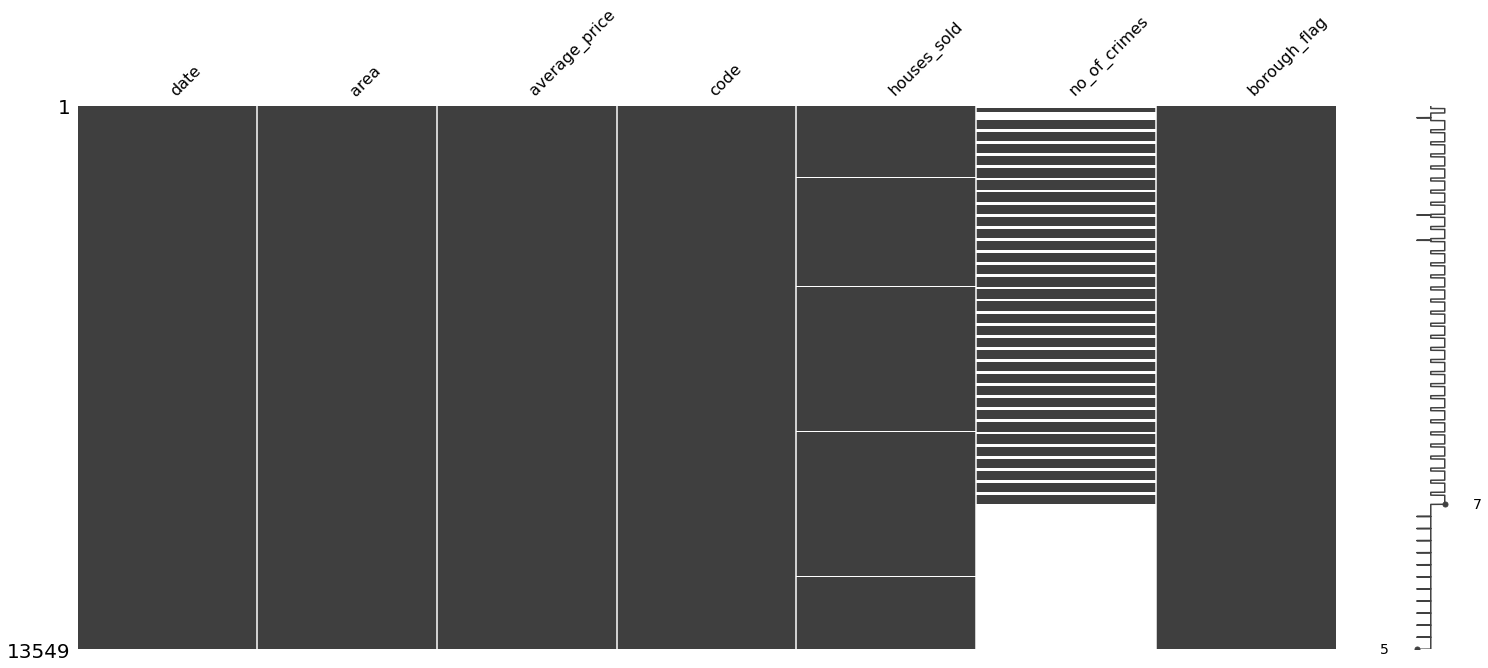

In [ ]:
display(df.describe());

msno.matrix(df);

จากการสังเกต จะเห็นได้ว่า:
- ค่า house_sold มีการหายไปเล็กน้อย
- ค่า no_of crimes หายไปหลายค่า


,median_salary,life_satisfaction,population_size,number_of_jobs,area_size,no_of_houses,borough_flag
count,"1,049.00",352.00,"1,018.00",931.00,666.00,666.00,"1,071.00"
mean,"27,977.79",7.49,"6,042,576.49","3,188,094.52","372,490.27","881,468.15",0.65
std,"6,412.81",0.20,"15,268,096.56","8,058,302.24","2,157,060.24","3,690,376.14",0.48
min,"15,684.00",7.00,"6,581.00","47,000.00",315.00,"5,009.00",0.00
25%,"23,857.00",7.35,"224,345.75","94,500.00","2,960.00","87,635.50",0.00
50%,"27,441.00",7.51,"294,603.50","157,000.00","4,323.00","102,402.00",1.00
75%,"30,932.00",7.64,"4,630,098.50","2,217,000.00","8,220.00","126,276.00",1.00
max,"61,636.00",7.96,"66,435,550.00","35,750,000.00","13,303,728.00","24,172,166.00",1.00


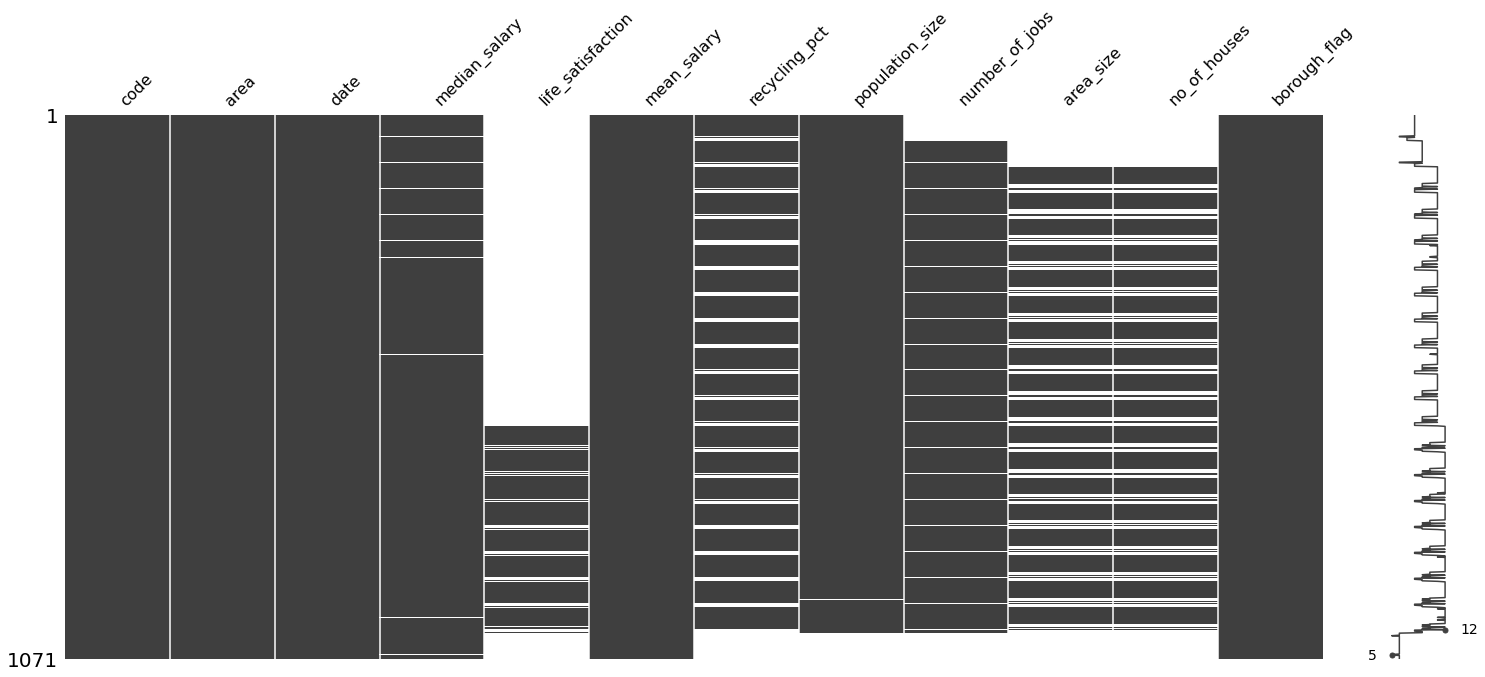

In [ ]:
display(df_1.describe())

msno.matrix(df_1);

Data Cleaning

In [ ]:
drop1 = pd.DataFrame(df)
drop1.drop(['no_of_crimes', 'houses_sold', 'code'], axis = 1)

,date,area,average_price,borough_flag
0,1995-01-01,city of london,91449,1
1,1995-02-01,city of london,82203,1
2,1995-03-01,city of london,79121,1
3,1995-04-01,city of london,77101,1
4,1995-05-01,city of london,84409,1
...,...,...,...,...
13544,2019-09-01,england,249942,0
13545,2019-10-01,england,249376,0
13546,2019-11-01,england,248515,0
13547,2019-12-01,england,250410,0


In [ ]:
drop2 = pd.DataFrame(df_1)
drop2.drop(['life_satisfaction','area_size','no_of_houses',], axis = 1)

,code,area,date,median_salary,mean_salary,recycling_pct,population_size,number_of_jobs,borough_flag
0,E09000001,city of london,1999-12-01,"33,020.00",48922,0,"6,581.00",nan,1
1,E09000002,barking and dagenham,1999-12-01,"21,480.00",23620,3,"162,444.00",nan,1
2,E09000003,barnet,1999-12-01,"19,568.00",23128,8,"313,469.00",nan,1
3,E09000004,bexley,1999-12-01,"18,621.00",21386,18,"217,458.00",nan,1
4,E09000005,brent,1999-12-01,"18,532.00",20911,6,"260,317.00",nan,1
...,...,...,...,...,...,...,...,...,...
1066,K03000001,great britain,2019-12-01,"30,446.00",37603,NaN,nan,nan,0
1067,K04000001,england and wales,2019-12-01,"30,500.00",37865,NaN,nan,nan,0
1068,N92000002,northern ireland,2019-12-01,"27,434.00",32083,NaN,nan,nan,0
1069,S92000003,scotland,2019-12-01,"30,000.00",34916,NaN,nan,nan,0


#EDA

In [ ]:
# แปลงวันที่ให้เป็นดัชนีเพื่อง่ายต่อการจัดการ
df = df.set_index(pd.to_datetime(df['date']))
df_1 = df_1.set_index(pd.to_datetime(df_1['date']))

del df['date']
del df_1['date']
df_1['mean_salary'] = df_1['mean_salary'].replace('-', np.NaN)
df_1['mean_salary'] = df_1['mean_salary'].replace('#', np.NaN)
df_1['mean_salary'] = df_1['mean_salary'].astype(float)

# สร้างตัวแปลเพื่อมาตัดชุดข้อมูล
prices_london = df[df['borough_flag'] == 1]
prices_england = df[df['area'] == 'england']
prices_north_east = df[df['area'] == 'north east']

# คำนวณราคาเฉลี่ยเพื่อตัดข้อมูลต่างๆ
london_mean_price = prices_london.groupby('date')['average_price'].mean()
england_mean_price = prices_england.groupby('date')['average_price'].mean()
north_east_mean_price = prices_north_east.groupby('date')['average_price'].mean()

#สั่ง print เพื่อให้เเน่ใจว่า Process ข้างบนสามารถทำงานลงมาถึงตรงนี้ได้
print('Processing Complete')

Processing Complete


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=london_mean_price.index, 
                         y=london_mean_price.values,
                         mode='lines',
                         name='London Mean House Price',
                        ))

fig.add_trace(go.Scatter(x=england_mean_price.index, 
                         y=england_mean_price.values,
                         mode='lines',
                         name='England Mean House Price',
                        ))

fig.add_trace(go.Scatter(x=north_east_mean_price.index, 
                         y=north_east_mean_price.values,
                         mode='lines',
                         name='North East Mean House Price',
                        ))


fig.update_layout(
    template='gridon',
    title='Average Monthly House Price',
    xaxis_title='Year',
    yaxis_title='Price (£)',
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    legend=dict(y=-.2, orientation='h'),
    shapes=[
        dict(
            type="line",
            x0='2016-06-01',
            x1='2016-06-01',
            y0=0,
            y1=london_mean_price.values.max()*1.2,
            line=dict(
            color="LightSalmon",
            dash="dashdot"
            )
        ),
        dict(
            type="rect",
            x0="2007-12-01",
            y0=0,
            x1="2009-06-01",
            y1=london_mean_price.values.max()*1.2,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        ),
        dict(
            type="rect",
            x0="2001-03-01",
            y0=0,
            x1="2001-11-01",
            y1=london_mean_price.values.max()*1.2,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    ],
    annotations=[
            dict(text="The Great Recession", x='2007-12-01', y=london_mean_price.values.max()*1.2),
            dict(text="Brexit Vote", x='2016-06-01', y=london_mean_price.values.max()*1.2),
            dict(text="Dot-Com Bubble Recession", x='2001-03-01', y=london_mean_price.values.max()*1.2)
    ]
)

fig.show()

เมื่อเเสดงกราฟออกมาเเล้วจะเห็นว่า ราคาบ้านใน London นั้นสูงกว่าค่าเฉลี่ยเมื่อเทียบกับของ England นอกจากนี้ยังทำให้ราคาของภูมิภาคตะวันออกเฉียงเหนือที่ค่อนข้างยากจนแคบลงอีกด้วย

เป็นที่ชัดเจนว่าภาวะเศรษฐกิจถดถอยทั่วโลกในปี 2008 ได้ปรับราคาบ้านโดยรวมอย่างรุนเเรงอย่างไรก็ตาม นี่เป็นเพียงราคาชั่วคราวเท่านั้น เเละ ราคาบ้านในลอนดอนก็ฟื้นตัวขึ้นตั้งเเต่นั้นมา 
การลงคะแนน Brexit ในปี 2016 ไม่ได้ส่งผลกระทบต่อราคาอย่างมีนัยสำคัญเเต่การเติบโตของราคาได้ลดลง

ตามที่คาดไว้ ภาวะถดถอยที่ตามมาหลัง ฟองสบูเเตก ไม่ส่งผลกระทบอย่างมีนัยสำคัญต่อราคาบ้านของ England เนื่องจากภาวะเศรษฐกิจถดถอยครั้งนี้ กระจุกตัวใน US เป็นส่วนใหญ่

In [ ]:
fig = px.line(prices_london, x=prices_london.index, y="average_price", color='area')

fig.update_layout(
    template='gridon',
    title='Average Monthly London House Price by Borough',
    xaxis_title='Year',
    yaxis_title='Price (£)',
    xaxis_showgrid=False,
    yaxis_showgrid=False
)

fig.show()

จากการสำรวจ จะเห็นได้ว่า:
- 
Kensington and Chelsea ในอดีตเคยเป็นและยังคงเป็นเขตเมืองที่แพงที่สุดในการซื้อบ้าน
- 
เมืองที่มีราคาแพงกว่ามีความผันผวนมากกว่าในราคาเฉลี่ย
-
Brent มีราคาบ้านที่ลดลงอย่างมีนัยสำคัญตั้งแต่ปี 2019

#กราฟแบบนี้อย่าหาทำ lol


In [ ]:
fig = px.line(london_mean_price, x='average_price', y=london_mean_price.index.year, color=london_mean_price.index.month)

fig.update_layout(
    template='gridon',
    title='YoY Average London House Price',
    xaxis_title='Values',
    yaxis_title='Year',
    xaxis_showgrid=False,
    yaxis_showgrid=False
)

fig.show()

# ตรงนี้ควร Scale ข้อมูลก่อนเเล้วค่อย พร็อทกราฟออกมา

In [ ]:
fig = px.line(london_mean_price, x=london_mean_price.index.month, y='average_price', color=london_mean_price.index.year)

fig.update_layout(
    template='gridon',
    title='YoY Average London House Price',
    xaxis_title='Values',
    yaxis_title='Year',
    xaxis_showgrid=False,
    yaxis_showgrid=False
)

fig.show()

In [ ]:
# คำนวณราคาเฉลี่ยรายปีต่อเขต
yearly_prices_london = prices_london.groupby('area').resample('y')['average_price'].mean()

# คำนวณการเปลี่ยนแปลงของเปอร์เซ็นต์ราคาเฉลี่ยต่อปี
yearly_prices_london_pct_ch = yearly_prices_london.groupby(level='area').apply(lambda x: x.pct_change())

yearly_prices_london_pct_ch = yearly_prices_london_pct_ch.unstack()
yearly_prices_london_pct_ch = yearly_prices_london_pct_ch.iloc[::-1]

del yearly_prices_london_pct_ch['1995-12-31']

In [ ]:
fig = go.Figure(data=go.Heatmap(
        z=yearly_prices_london_pct_ch.values,
        x=yearly_prices_london_pct_ch.columns,
        y=yearly_prices_london_pct_ch.index,
        colorscale='Cividis'))

fig.update_layout(
    title='Average London House Price Percentage Change',
    title_x=0.5,
    yaxis_nticks=33,
    xaxis_title='Year',
    yaxis_title='Borough'
)

fig.show()

การเปลี่ยนแปลงของราคาบ้าน ปี 2000 จะเห็นว่าราคาบ้านขึ้นสูงที่สุด ช่วงปี ​​​​2015 ก็เห็นว่าราคามีแนวโน้มสูงขึ้น แต่ก็ค่อนข้างคงที่ เเละ ลดลงตั้งแต่นั้นเป็นต้นมา

In [ ]:
london_mean_values = prices_london.groupby('area').resample('y').mean().reset_index()
df_1 = df_1.groupby('area').resample('y').mean().reset_index()
london_mean_values = pd.merge(london_mean_values, df_1, on=['area', 'date'], how='left')

del london_mean_values['borough_flag_x']
del london_mean_values['borough_flag_y']

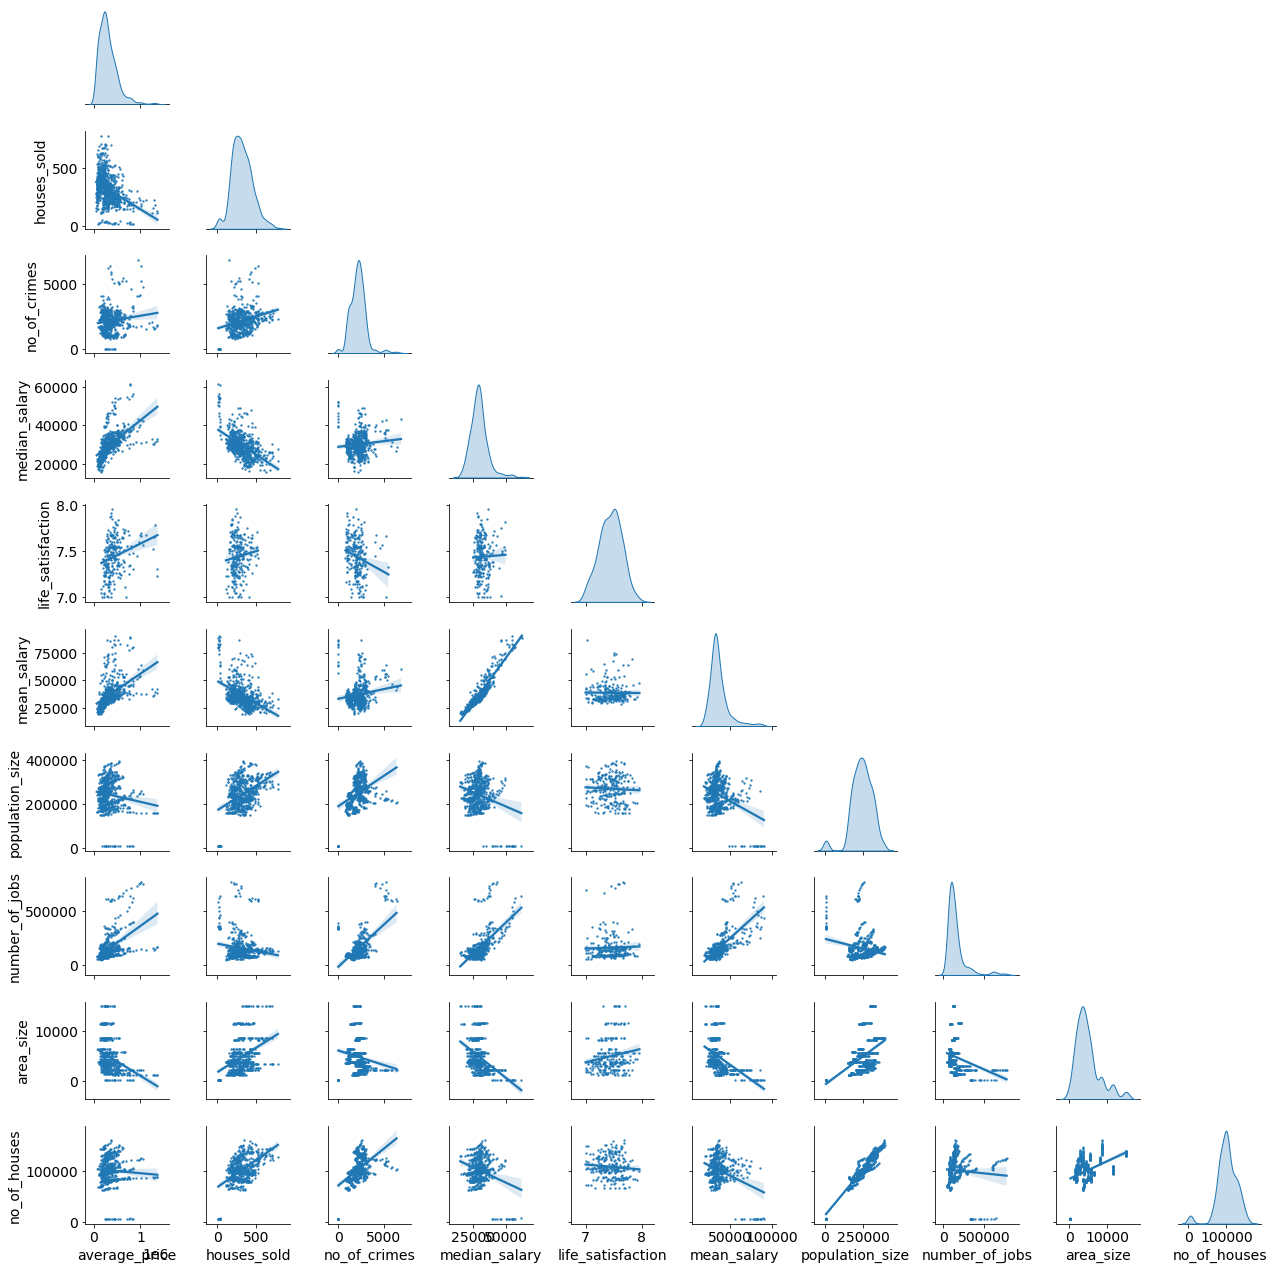

In [ ]:
sns.pairplot(london_mean_values, corner=True, kind='reg', diag_kind='kde', plot_kws=dict(scatter_kws=dict(s=2)), height=1.8)
plt.show()

ตรงนี้จะเห็นว่า ราคาบ้านโดยเฉลี่ยมีความสัมพันธ์เชิงบวกสูงสุดกับค่ามัธยฐานและเงินเดือนเฉลี่ยของผู้อาศัยในเเต่ละเขต
 สิ่งนี้สมเหตุสมผลเนื่องจากผู้มีรายได้สูงจะสามารถซื้อย่านที่มีราคาเเพงกว่าได้ 
อย่างไรก็ตามสิ่งนี้อาจจะนำไปสู่การเเบ่งพื้นที่เเละโอกาสการซื้อที่อยู่อาศัยราคาถูกนั้นน้อยลง

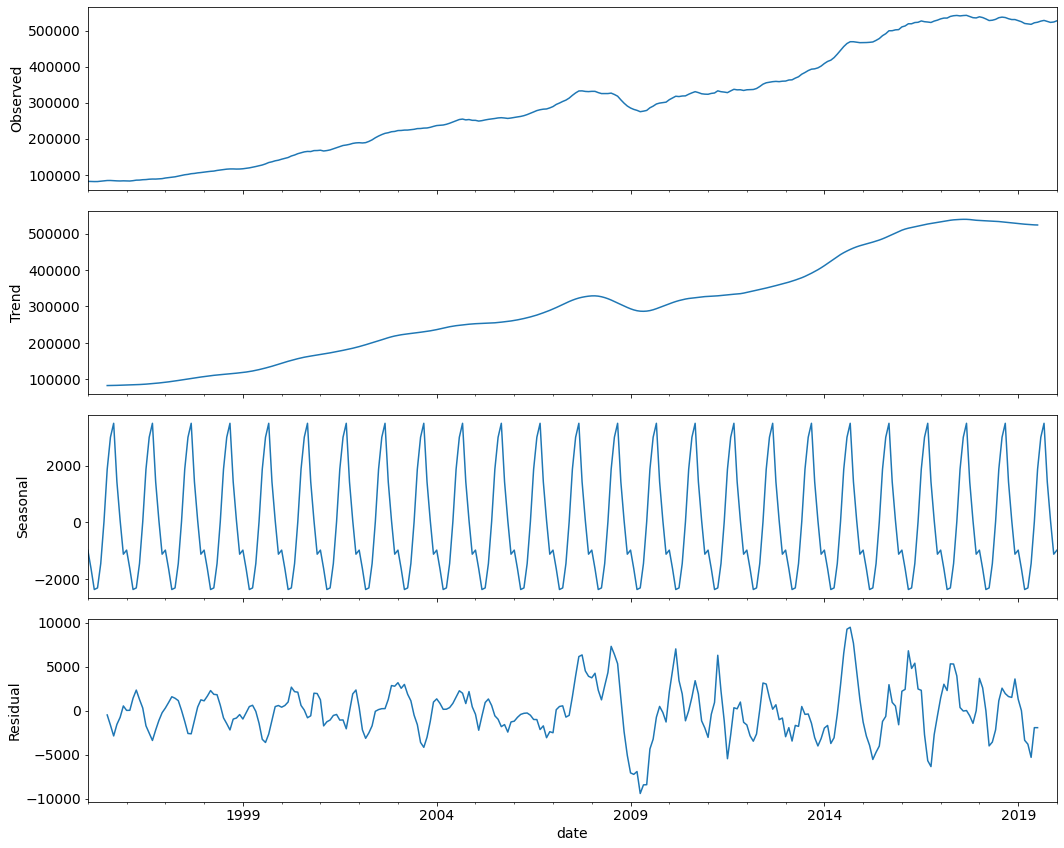

In [ ]:
decomposition = sm.tsa.seasonal_decompose(london_mean_price, model='additive')
fig = decomposition.plot()
fig.show()

Test Stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller

series = df['average_price'].values
# ADF Test
result = adfuller(series, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')


ADF Statistic: -9.658956298499412
p-value: 1.3698558910241896e-16
Series is Stationary


#Feature Engineer


สิ่งที่จะทำคือการนำ วันที่ เเละ ราคาเฉลี่ย มาคาดเดาราคาในอนาคต

In [ ]:
model_df = pd.DataFrame(london_mean_price).reset_index()
model_df = model_df.rename(columns={'date': 'ds', 'average_price': 'y'})

#Model

ในที่นี่เลือกใช้ Phophet Model โดย โมเดลตัวนี้เป็น Open source ที่ใช้สำหรับการ Forcast พัฒนาโดยทีม Facebook Core Data Science โดยมีประสิทธิภาพการทำงานที่ รวดเร็ว เเม่นยำ จนถึงค่าผิดปกติ เเละสามารถเเก้ไขได้เอง 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


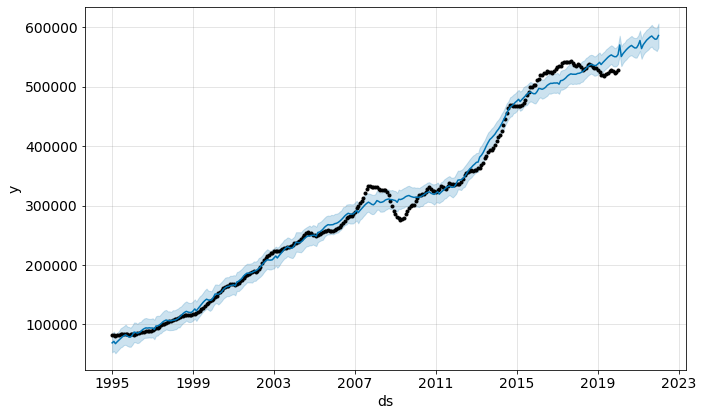

In [ ]:
m = Prophet()
m.fit(model_df)

future = m.make_future_dataframe(periods=24, freq='M')

forecast = m.predict(future)

fig1 = m.plot(forecast)

#Member

รพีพัฒน์ สันติวรพงศ์ 16020702025 เลขที่ 10


ปรางวลัย สว่างเมฆ 1620703528 เลขที่ 14

นฤเบศ หวันธรรมมา 1620705309 เลขที่ 23

#Reference

Data

https://www.kaggle.com/justinas/house-prices-in-london/data?select=housing_in_london_monthly_variables.csv




https://www.kaggle.com/sauravagarwal/eda-simplest-way

https://www.kaggle.com/korfanakis/housing-in-london-eda-with-pandas-and-gif

https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

https://towardsdatascience.com/most-useful-python-functions-for-time-series-analysis-ed1a9cb3aa8b

https://machinelearningmastery.com/time-series-data-stationary-python/

https://www.kaggle.com/prashant111/complete-guide-on-time-series-analysis-in-python

https://blog.datath.com/time-series-forecasting/